## Run POD on the downsampled PIV data/results from autoencoder
originally a matlab script

In [1]:
import h5py
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# parameters
D       = 196.5;    # Model diameter in mm
Uinf    = 15;       # Nominal free stream velocity
fPIV    = 720;      # PIV sampling frequency
dt      = 1/fPIV;   # Delta t between image pairs

In [37]:
#=================== downsampled data ======================
filename = "../PIV4_downsampled_by8.h5" # .h5 file of data
hf = h5py.File(filename,'r')
z = np.array(hf.get('z'))
y = np.array(hf.get('y'))
vy = np.array(hf.get('vy'))
vz = np.array(hf.get('vz'))
hf.close()
print("Finished loading data.")
# print(vy.shape)
[nt,nz,ny] = vz.shape

vy = np.transpose(vy,[2,1,0])
vz = np.transpose(vz,[2,1,0]) #(ny,nz,nt)

Finished loading data.


In [28]:
#================= autoencoder data ========================
filename = '../../../Scripts/PIV/Autoencoder/MD_2__2022_02_02__16_51_24/results.h5'
hf = h5py.File(filename,'r')
decomp_test = np.array(hf.get('modes_test'))
hf.close()
print("Finished loading data.")
[latent_dim,nt,ny,nz,nu] = decomp_test.shape
print(latent_dim,nt,ny,nz,nu)

WhichDecoder = 0
vy = decomp_test[WhichDecoder,:,:,:,0].astype('float64')
vy = np.transpose(vy,[1,2,0])
vz = decomp_test[WhichDecoder,:,:,:,1].astype('float64')
vz = np.transpose(vz,[1,2,0])
print(vz.shape)

Finished loading data.
2 600 21 24 2
(21, 24, 600)


In [38]:
#==================== prepare data =========================
# build matrix
Q = np.vstack((vz,vy)) # new shape [2*ny,nz,nt]
Q = np.reshape(Q,(2*nz*ny,nt)) # [2*ny*nz,nt]
v_true = np.copy(Q)
print(Q.shape)

# remove mean
x_mean = np.mean(Q,axis=1)
for ti in range(0,nt):
    Q[:,ti] = Q[:,ti] - x_mean;

weight = np.ones((2*ny*nz,1))
# choose POD method
if Q.shape[1] > Q.shape[0]:
    TypePOD = 1
    print("Use classic POD, Nx < Nt.")
else:
    TypePOD = 2
    print("Use snapshot POD, Nx > Nt.")

(1008, 2732)
Use classic POD, Nx < Nt.


In [39]:
#================== Calculate POD ==========================
print("Calculating POD...")
# TypePOD = 1
if TypePOD == 1:
    C = Q @ ((Q.T)*(weight.T)) # 2-point spatial correlation tesnsor: Q*Q'
    lam,Phi = np.linalg.eigh(C) # right eigenvectors and eigenvalues
    idx = np.argsort(lam) # sort
    idx = np.flip(idx)
    Q_POD = Phi[:,idx]
    lam = lam[idx]
    # normalise energy in the weighted inner product
    normQ = (np.matmul(Q_POD.T,Q_POD*weight).real)**0.5
    Q_POD = Q_POD@np.diag(1/np.diag(normQ))
elif TypePOD == 2:
    C = (Q.T) @ (Q*weight) # 2-point temporal correlation tesnsor: Q'*Q 
    lam,Phi = np.linalg.eigh(C)
    idx = np.argsort(np.abs(lam)) # sort
    idx = np.flip(idx)
    Phi = Phi[:,idx]
    lam = lam[idx]
    # get spatial POD modes: PSI = Q*Phi
    Q_POD = (Q@Phi)*(1/(lam**0.5).T)

print("POD done.")

Calculating POD...
POD done.


C:\Users\ym917\AppData\Local\Temp\ipykernel_16476\3103656413.py:12: RuntimeWarning: invalid value encountered in sqrt
  normQ = (np.matmul(Q_POD.T,Q_POD*weight).real)**0.5


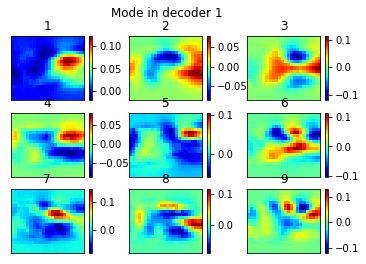

In [40]:
#======================= plot ==============================
PlotWhichVelocity = 'v' 

fig = plt.figure(1)
title = "Mode in decoder " + str(WhichDecoder+1)
# title = "POD Modes "+PlotWhichVelocity
plt.suptitle(title)
for iphi in range(9):
    ax = plt.subplot(3,3,iphi+1,title=str(iphi+1),xticks=[],yticks=[])
    pltV = Q_POD[:,iphi];
    pltV = np.reshape(pltV,[2*ny,nz])
    if PlotWhichVelocity == 'w': # Q was built [vz,vy]
        pltV = pltV[0:ny,:]
    elif PlotWhichVelocity == 'v':
        pltV = pltV[ny:,:]
    elif PlotWhichVelocity == 'V':
        pltV = (pltV[0:ny,:]**2 + pltV[ny:,:]**2)**0.5
    
    ax = plt.imshow(pltV,'jet')
    plt.colorbar()

In [55]:
energy[599]

0.9936645267358626

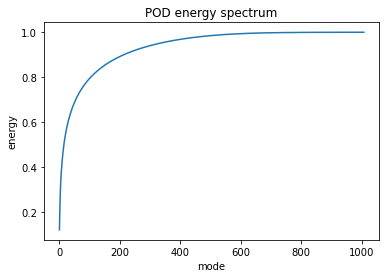

In [51]:
#================== plot spectrum =================================
energy = np.cumsum(lam/np.sum(lam))
plt.figure()
plt.title('POD energy spectrum')
plt.plot(energy)
plt.ylabel('energy')
plt.xlabel('mode')
plt.show()

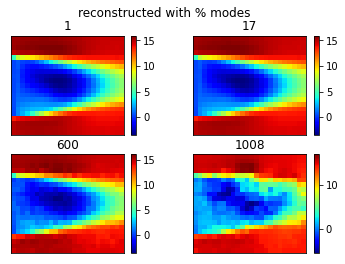

In [68]:

#=================== reconstruct (snapshot method) ==========================
time = 0 # which snapshot?
modes = np.array([1,17,600,1008])
PlotWhichVelocity = 2 # 1 -> v, 2 -> w, 3 -> V
plt.figure(2)
plt.suptitle("reconstructed with % modes")

for i in range(4):
    if TypePOD ==1:
        # temporal coefficient A
        A = Q.T @ Phi #(nt,nx)
        Q_add = Phi[:,0:modes[i]] @ A[:,0:modes[i]].T
        Q_add = Q_add[:,time]
    elif TypePOD == 2:
        # spatial coefficient A
        A = Q @ Phi #(nx,nt)
        Q_add = A[:,0:modes[i]] @ Phi[:,0:modes[i]].T
        Q_add = Q_add[:,time]

    rebuildv = x_mean + Q_add # add contribution
    rebuildv = np.reshape(rebuildv,[2,ny,nz]) # new shape (2,ny,nz). Velocity 1 is v. Velocity 2 is w.

    if PlotWhichVelocity == 2:
        rebuildv = rebuildv[0,:,:]
    elif PlotWhichVelocity == 1:
        rebuildv = rebuildv[1,:,:]
    elif PlotWhichVelocity == 3:
        rebuildv = (rebuildv[0,:,:]**2 + rebuildv[1,:,:]**2)**0.5

    ax = plt.subplot(2,2,i+1,title=str(modes[i]),xticks=[],yticks=[])
    ax = plt.imshow(rebuildv.real,'jet')
    plt.colorbar()
plt.show()

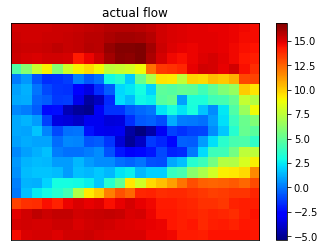

In [43]:
#==================== actual flow =========================
time = 0
PlotWhichVelocity = 2

v = vy[:,:,time]
w = vz[:,:,time]
V = (v**2 + w**2)**0.5

plt.figure(3)
ax = plt.subplot(1,1,1,title="actual flow",xticks=[],yticks=[])
if PlotWhichVelocity == 1:
    ax = plt.imshow(v,'jet')
elif PlotWhichVelocity == 2:
    ax = plt.imshow(w,'jet')
elif PlotWhichVelocity == 3:
    ax = plt.imshow(V,'jet')
plt.colorbar()
plt.show()

In [66]:
# =============================== Absolute error =============================== 
i = 600

if TypePOD ==1:
    # temporal coefficient A
    A = Q.T @ Phi #(nt,nx)
    Q_add = Phi[:,:i] @ A[:,:i].T
elif TypePOD == 2:
    # spatial coefficient A
    A = Q @ Phi #(nx,nt)
    Q_add = A[:,:i] @ Phi[:,:i].T


rebuildv = x_mean[:,None] + Q_add # add contribution
e = np.abs(rebuildv-v_true) 
e_mean = np.sum(e)/nt
print('mean absolute error per snapshot',e_mean)

mean absolute error per snapshot 849.9681883845212
